In [0]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
import os
import matplotlib.gridspec as gridspec
import matplotlib.ticker as ticker
sns.set_style('whitegrid')
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from keras.layers import Input
from keras.models import Model
from keras.layers import Dense
from keras.optimizers import Adam
#from generator import DataGenerator
import keras
from sklearn.model_selection import train_test_split
from keras.applications.densenet import DenseNet121, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from PIL import Image
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

In [4]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [5]:
raw_data = pd.read_csv('/content/gdrive/My Drive/Colab/Data_Entry_2017.csv')
raw_data.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN


In [6]:
print('shape of data:', raw_data.shape)

shape of data: (112120, 12)


In [7]:
raw_data.describe()

,Follow-up #,Patient ID,Patient Age,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
count,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,0.0
mean,8.573751,14346.381743,46.901463,2646.078844,2486.438842,0.155649,0.155649,NaN
std,15.406320,8403.876972,16.839923,341.246429,401.268227,0.016174,0.016174,NaN
min,0.000000,1.000000,1.000000,1143.000000,966.000000,0.115000,0.115000,NaN
25%,0.000000,7310.750000,35.000000,2500.000000,2048.000000,0.143000,0.143000,NaN
50%,3.000000,13993.000000,49.000000,2518.000000,2544.000000,0.143000,0.143000,NaN
75%,10.000000,20673.000000,59.000000,2992.000000,2991.000000,0.168000,0.168000,NaN
max,183.000000,30805.000000,414.000000,3827.000000,4715.000000,0.198800,0.198800,NaN


In [0]:
#We are dropping columns which are useless for our project

In [0]:
data = raw_data[['Image Index', 'Finding Labels', 'Follow-up #', 'Patient ID', 'Patient Age', 'Patient Gender']]

In [10]:
data.describe()

,Follow-up #,Patient ID,Patient Age
count,112120.000000,112120.000000,112120.000000
mean,8.573751,14346.381743,46.901463
std,15.406320,8403.876972,16.839923
min,0.000000,1.000000,1.000000
25%,0.000000,7310.750000,35.000000
50%,3.000000,13993.000000,49.000000
75%,10.000000,20673.000000,59.000000
max,183.000000,30805.000000,414.000000


In [0]:
#We are removing the rows which have patients older than 100

In [12]:
#drop unused columns
data = data[['Image Index','Finding Labels','Follow-up #','Patient ID','Patient Age','Patient Gender']]

# removing the rows which have patient_age >100
total = len(data)
print('No. of rows before removing rows having age >100 : ',len(data))
data = data[data['Patient Age']<100]
print('No. of rows after removing rows having age >100 : ',len(data))
print('No. of datapoints having age > 100 : ',total-len(data))

No. of rows before removing rows having age >100 :  112120
No. of rows after removing rows having age >100 :  112104
No. of datapoints having age > 100 :  16


In [0]:
# rows having no. of disease
data['Labels_Count'] = data['Finding Labels'].apply(lambda text: len(text.split('|')) if(text != 'No Finding') else 0)

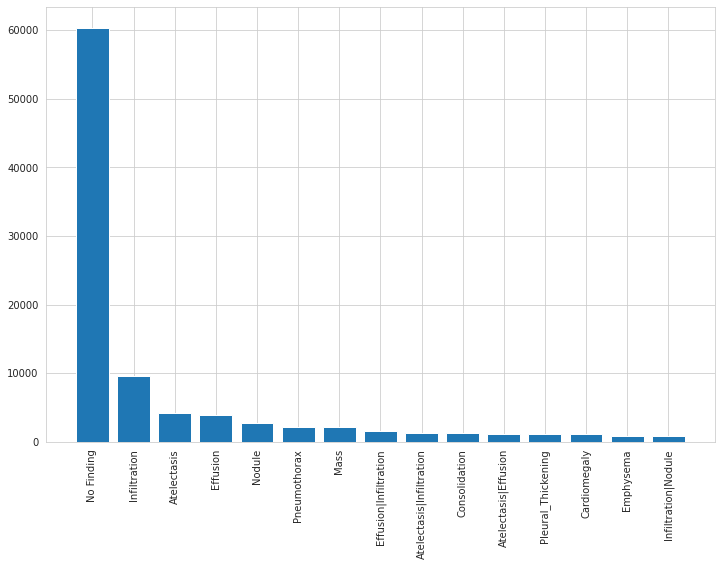

In [14]:

label_counts = data['Finding Labels'].value_counts()[:15]
fig, ax1 = plt.subplots(1,1,figsize = (12, 8))
ax1.bar(np.arange(len(label_counts))+0.5, label_counts)
ax1.set_xticks(np.arange(len(label_counts))+0.5)
_ = ax1.set_xticklabels(label_counts.index, rotation = 90)

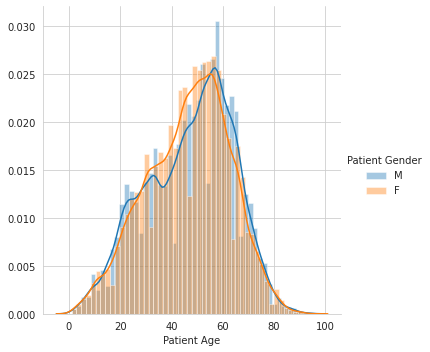

In [15]:
#Age distribution
#plt.figure(figsize=(20,15))
sns.FacetGrid(data,hue='Patient Gender',size=5).map(sns.distplot,'Patient Age').add_legend()
plt.show()

In [0]:
#observation - Both gender have almost same distribution

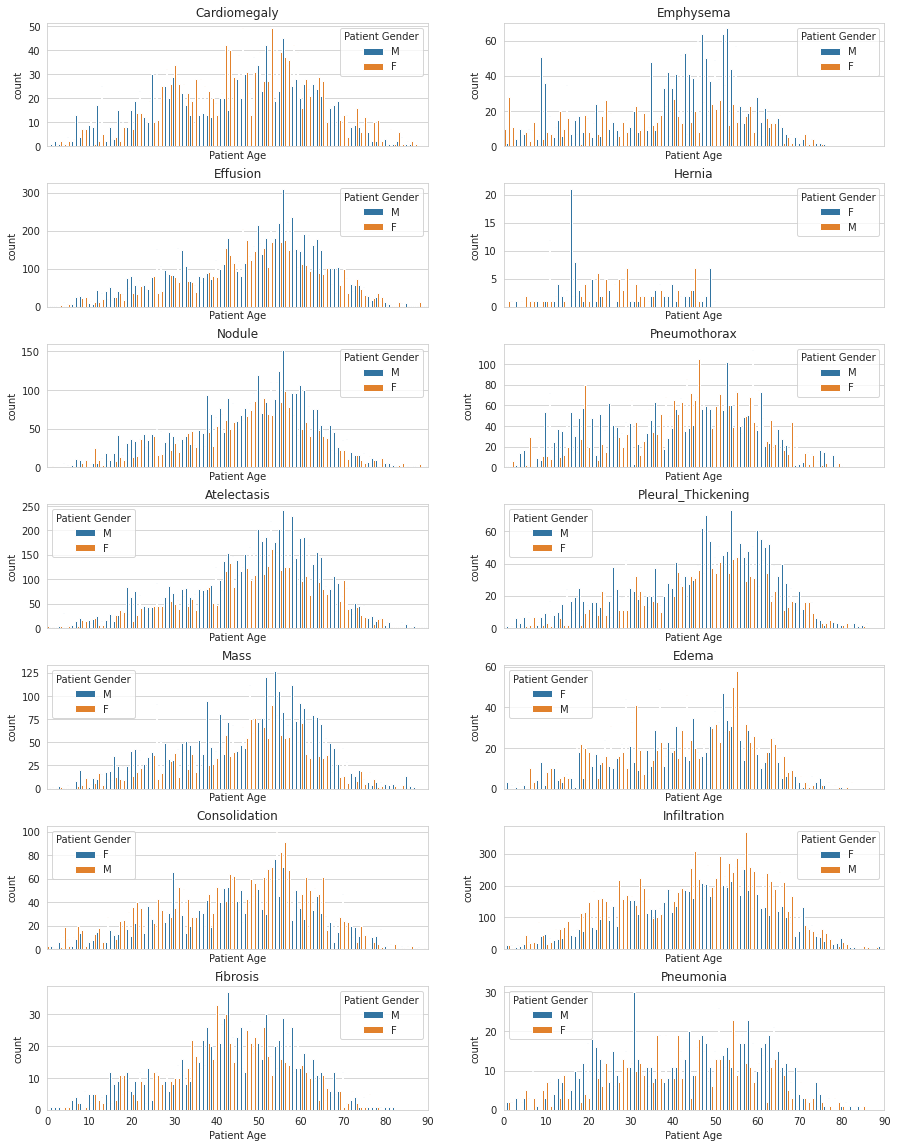

In [17]:
#Disease distribution by age and sex

f, axarr = plt.subplots(7, 2, sharex=True,figsize=(15, 20))
pathology_list = ['Cardiomegaly','Emphysema','Effusion','Hernia','Nodule','Pneumothorax','Atelectasis','Pleural_Thickening','Mass','Edema','Consolidation','Infiltration','Fibrosis','Pneumonia']
df = data[data['Finding Labels'] != 'No Finding']
i=0
j=0
x=np.arange(0,100,10)
for pathology in pathology_list :
    index = []
    for k in range(len(df)):
        if pathology in df.iloc[k]['Finding Labels']:
            index.append(k)
    g=sns.countplot(x='Patient Age', hue="Patient Gender",data=df.iloc[index], ax=axarr[i, j])
    axarr[i, j].set_title(pathology)   
    g.set_xlim(0,90)
    g.set_xticks(x)
    g.set_xticklabels(x)
    j=(j+1)%2
    if j==0:
        i=(i+1)%7
f.subplots_adjust(hspace=0.3)

In [18]:
#No. of each disease by patient gender

for pathology in pathology_list :
    data[pathology] = data['Finding Labels'].apply(lambda x: 1 if pathology in x else 0)

data.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,Labels_Count,Cardiomegaly,Emphysema,Effusion,Hernia,Nodule,Pneumothorax,Atelectasis,Pleural_Thickening,Mass,Edema,Consolidation,Infiltration,Fibrosis,Pneumonia
0,00000001_000.png,Cardiomegaly,0,1,58,M,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,2,1,1,0,0,0,0,0,0,0,0,0,0,0,0
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,2,1,0,1,0,0,0,0,0,0,0,0,0,0,0
3,00000002_000.png,No Finding,0,2,81,M,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,00000003_000.png,Hernia,0,3,81,F,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0


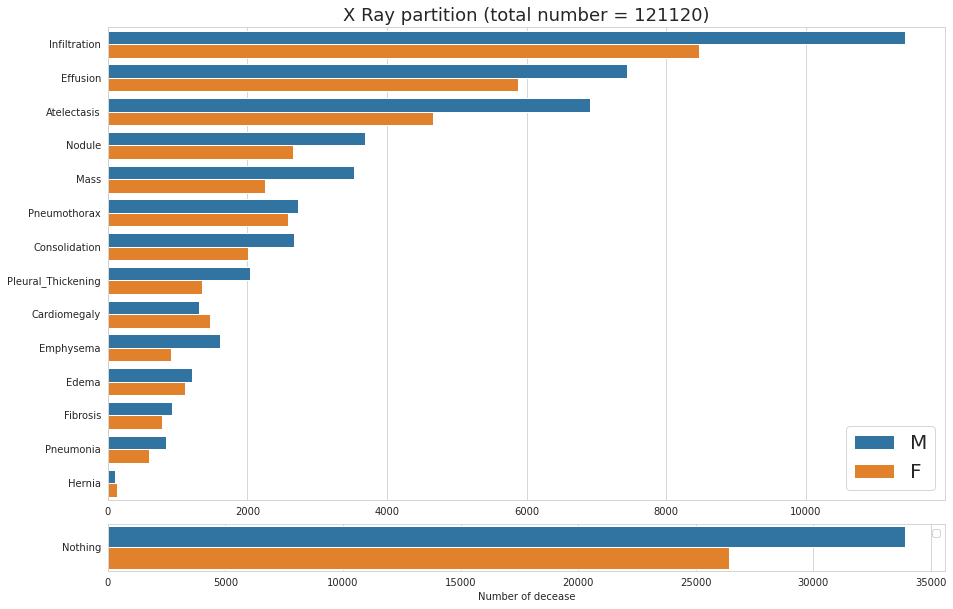

In [19]:
plt.figure(figsize=(15,10))
gs = gridspec.GridSpec(8,1)
ax1 = plt.subplot(gs[:7, :])
ax2 = plt.subplot(gs[7, :])
data1 = pd.melt(data,
             id_vars=['Patient Gender'],
             value_vars = list(pathology_list),
             var_name = 'Category',
             value_name = 'Count')
data1 = data1.loc[data1.Count>0]
g=sns.countplot(y='Category',hue='Patient Gender',data=data1, ax=ax1, order = data1['Category'].value_counts().index)
ax1.set( ylabel="",xlabel="")
ax1.legend(fontsize=20)
ax1.set_title('X Ray partition (total number = 121120)',fontsize=18);

data['Nothing']=data['Finding Labels'].apply(lambda x: 1 if 'No Finding' in x else 0)

data2 = pd.melt(data,
             id_vars=['Patient Gender'],
             value_vars = list(['Nothing']),
             var_name = 'Category',
             value_name = 'Count')
data2 = data2.loc[data2.Count>0]
g=sns.countplot(y='Category',hue='Patient Gender',data=data2,ax=ax2)
ax2.set( ylabel="",xlabel="Number of decease")
ax2.legend('')
plt.subplots_adjust(hspace=.5)

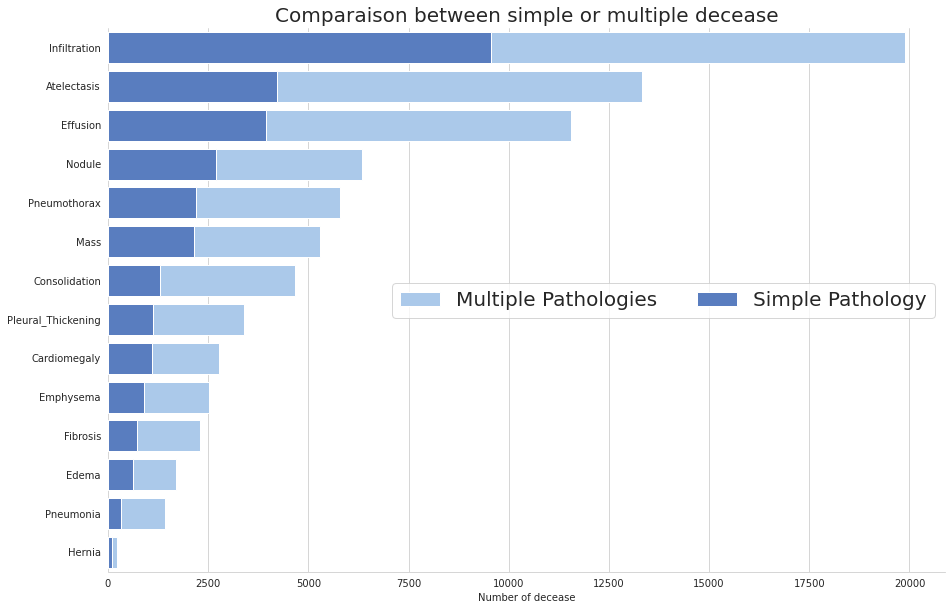

In [20]:
#ratio between one and multiple disease

df=data.groupby('Finding Labels').count().sort_values('Patient ID',ascending=False)
df1=df[['|' in index for index in df.index]].copy()
df2=df[['|' not in index for index in df.index]]
df2=df2[['No Finding' not in index for index in df2.index]]
df2['Finding Labels']=df2.index.values
df1['Finding Labels']=df1.index.values

f, ax = plt.subplots(sharex=True,figsize=(15, 10))
sns.set_color_codes("pastel")
g=sns.countplot(y='Category',data=data1, ax=ax, order = data1['Category'].value_counts().index,color='b',label="Multiple Pathologies")
sns.set_color_codes("muted")
g=sns.barplot(x='Patient ID',y='Finding Labels',data=df2, ax=ax, color="b",label="Simple Pathology")
ax.legend(ncol=2, loc="center right", frameon=True,fontsize=20)
ax.set( ylabel="",xlabel="Number of decease")
ax.set_title("Comparaison between simple or multiple decease",fontsize=20)      
sns.despine(left=True)

In [21]:
#Plot most important pathologies groups for each desease

#we just keep groups of pathologies which appear more than 30 times
df3=df1.loc[df1['Patient ID']>30,['Patient ID','Finding Labels']]

for pathology in pathology_list:
    df3[pathology]=df3.apply(lambda x: x['Patient ID'] if pathology in x['Finding Labels'] else 0, axis=1)

df3.head(20)

,Patient ID,Finding Labels,Cardiomegaly,Emphysema,Effusion,Hernia,Nodule,Pneumothorax,Atelectasis,Pleural_Thickening,Mass,Edema,Consolidation,Infiltration,Fibrosis,Pneumonia
Finding Labels,,,,,,,,,,,,,,,,
Effusion|Infiltration,1603,Effusion|Infiltration,0,0,1603,0,0,0,0,0,0,0,0,1603,0,0
Atelectasis|Infiltration,1350,Atelectasis|Infiltration,0,0,0,0,0,0,1350,0,0,0,0,1350,0,0
Atelectasis|Effusion,1165,Atelectasis|Effusion,0,0,1165,0,0,0,1165,0,0,0,0,0,0,0
Infiltration|Nodule,829,Infiltration|Nodule,0,0,0,0,829,0,0,0,0,0,0,829,0,0
Atelectasis|Effusion|Infiltration,737,Atelectasis|Effusion|Infiltration,0,0,737,0,0,0,737,0,0,0,0,737,0,0
Cardiomegaly|Effusion,484,Cardiomegaly|Effusion,484,0,484,0,0,0,0,0,0,0,0,0,0,0
Consolidation|Infiltration,441,Consolidation|Infiltration,0,0,0,0,0,0,0,0,0,0,441,441,0,0
Infiltration|Mass,418,Infiltration|Mass,0,0,0,0,0,0,0,0,418,0,0,418,0,0
Effusion|Pneumothorax,403,Effusion|Pneumothorax,0,0,403,0,0,403,0,0,0,0,0,0,0,0


In [0]:
# Application of DENSENET on NIH Chest X-Ray

In [23]:
# Creating data for model


data = data[data['Patient Age']<100] #removing datapoints which having age greater than 100
data_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('..', 'input', 'images*', '*', '*.png'))}
print('Scans found:', len(data_image_paths), ', Total Headers', data.shape[0])
data['path'] = data['Image Index'].map(data_image_paths.get)
data['Patient Age'] = data['Patient Age'].map(lambda x: int(x))
data.sample(3)

Scans found: 0 , Total Headers 112104


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,Labels_Count,Cardiomegaly,Emphysema,Effusion,Hernia,Nodule,Pneumothorax,Atelectasis,Pleural_Thickening,Mass,Edema,Consolidation,Infiltration,Fibrosis,Pneumonia,Nothing,path
110392,00030076_000.png,Pneumothorax,0,30076,59,F,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,None
106442,00028677_003.png,Consolidation|Emphysema,3,28677,49,M,2,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,None
75813,00018610_013.png,No Finding,13,18610,64,M,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,None


In [24]:
data['Finding Labels'] = data['Finding Labels'].map(lambda x: x.replace('No Finding', ''))
from itertools import chain
all_labels = np.unique(list(chain(*data['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        data[c_label] = data['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
data.sample(3)

All Labels (14): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,Labels_Count,Cardiomegaly,Emphysema,Effusion,Hernia,Nodule,Pneumothorax,Atelectasis,Pleural_Thickening,Mass,Edema,Consolidation,Infiltration,Fibrosis,Pneumonia,Nothing,path
13882,00003578_000.png,,0,3578,44,F,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,None
103338,00027562_000.png,,0,27562,40,F,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,None
94447,00024216_000.png,,0,24216,34,M,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,None


In [25]:
# keep at least 1000 cases
MIN_CASES = 1000
all_labels = [c_label for c_label in all_labels if data[c_label].sum()>MIN_CASES]
print('Clean Labels ({})'.format(len(all_labels)), 
      [(c_label,int(data[c_label].sum())) for c_label in all_labels])

Clean Labels (13) [('Atelectasis', 11558), ('Cardiomegaly', 2776), ('Consolidation', 4667), ('Edema', 2302), ('Effusion', 13316), ('Emphysema', 2516), ('Fibrosis', 1686), ('Infiltration', 19891), ('Mass', 5779), ('Nodule', 6331), ('Pleural_Thickening', 3384), ('Pneumonia', 1430), ('Pneumothorax', 5301)]


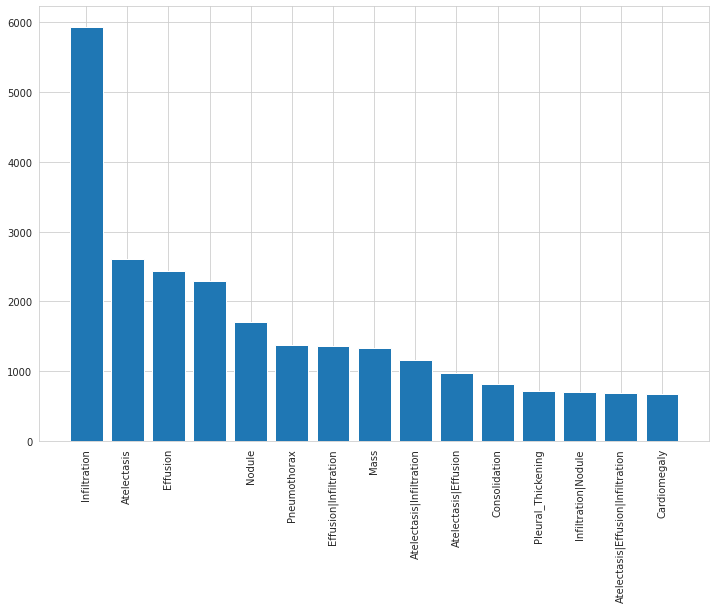

In [26]:
# since the dataset is very unbiased, we can resample it to be a more reasonable collection
# weight is 0.04 + number of findings
sample_weights = data['Finding Labels'].map(lambda x: len(x.split('|')) if len(x)>0 else 0).values + 4e-2
sample_weights /= sample_weights.sum()
data = data.sample(40000, weights=sample_weights)

label_counts = data['Finding Labels'].value_counts()[:15]
fig, ax1 = plt.subplots(1,1,figsize = (12, 8))
ax1.bar(np.arange(len(label_counts))+0.5, label_counts)
ax1.set_xticks(np.arange(len(label_counts))+0.5)
_ = ax1.set_xticklabels(label_counts.index, rotation = 90)



In [0]:
# creating vector of diseases
data['disease_vec'] = data.apply(lambda x: [x[all_labels].values], 1).map(lambda x: x[0])

In [0]:
data['disease_vec'].describe()

In [0]:
train_df, test_df = train_test_split(data, 
                                   test_size = 0.20, 
                                   random_state = 2018,
                                   stratify = data['Finding Labels'].map(lambda x: x[:4]))
print('train', train_df.shape[0], 'test', test_df.shape[0])

In [0]:
train_df, valid_df = train_test_split(train_df, 
                                   test_size = 0.10, 
                                   random_state = 2018,
                                   stratify = train_df['Finding Labels'].map(lambda x: x[:4]))
print('train', train_df.shape[0], 'valid', valid_df.shape[0])

In [0]:
def flow_from_dataframe(img_data_gen, in_df, path_col, y_col, **dflow_args):
    base_dir = os.path.dirname(in_df[path_col].values[0])
    print('## Ignore next message from keras, values are replaced anyways')
    df_gen = img_data_gen.flow_from_directory(base_dir, 
                                     class_mode = 'sparse',
                                    **dflow_args)
    df_gen.filenames = in_df[path_col].values
    df_gen.classes = np.stack(in_df[y_col].values)
    df_gen.samples = in_df.shape[0]
    df_gen.n = in_df.shape[0]
    df_gen._set_index_array()
    df_gen.directory = '' # since we have the full path
    print('Reinserting dataframe: {} images'.format(in_df.shape[0]))
    return df_gen

In [0]:
IMG_SIZE = (224, 224) # slightly smaller than vgg16 normally expects
core_idg_dense = ImageDataGenerator()

In [0]:

train_gen = flow_from_dataframe(core_idg_dense, train_df, 
                             path_col = 'path',
                            y_col = 'disease_vec', 
                            target_size = IMG_SIZE,
                             color_mode = 'rgb',
                            batch_size = 16)

valid_gen = flow_from_dataframe(core_idg_dense, valid_df, 
                             path_col = 'path',
                            y_col = 'disease_vec', 
                            target_size = IMG_SIZE,
                             color_mode = 'rgb',
                            batch_size = 32) # we can use much larger batches for evaluation
# used a fixed dataset for evaluating the algorithm
test_X, test_Y = next(flow_from_dataframe(core_idg_dense, 
                               test_df, 
                             path_col = 'path',
                            y_col = 'disease_vec', 
                            target_size = IMG_SIZE,
                             color_mode = 'rgb',
                            batch_size = 8000)) # one big batch
# used a fixed dataset for final evaluation

In [0]:
t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0])
    c_ax.set_title(', '.join([n_class for n_class, n_score in zip(all_labels, c_y) 
                             if n_score>0.5]))
    c_ax.axis('off')

In [0]:
###
### dense net model
###
###
img_in = Input(t_x.shape[1:])              #input of model 
model = DenseNet121(include_top= False , # remove  the 3 fully-connected layers at the top of the network
                weights='imagenet',      # pre train weight 
                input_tensor= img_in, 
                input_shape= t_x.shape[1:],
                pooling ='avg') 

x = model.output  
predictions = Dense(len(all_labels), activation="sigmoid", name="predictions")(x)    # fuly connected layer for predict class 
model = Model(inputs=img_in, outputs=predictions)

In [0]:
optimizer = Adam(lr=0.001)
model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=[keras.metrics.binary_accuracy])

In [0]:
history = model.fit_generator(train_gen, 
                                  steps_per_epoch=100,
                                  validation_data = valid_gen, 
                                  epochs = 20)

In [0]:
y_pred = model.predict(test_X)

In [0]:
# look at how often the algorithm predicts certain diagnoses 
for c_label, p_count, t_count in zip(all_labels, 
                                     100*np.mean(y_pred,0), 
                                     100*np.mean(test_Y,0)):
    print('%s: actual: %2.2f%%, predicted: %2.2f%%' % (c_label, t_count, p_count))

In [0]:
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
for (idx, c_label) in enumerate(all_labels):
    fpr, tpr, thresholds = roc_curve(test_Y[:,idx].astype(int), y_pred[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig('trained_net.png')

In [0]:
roc_auc_score(test_Y.astype(int), y_pred)

In [0]:
history = model.fit_generator(train_gen, 
                                  steps_per_epoch=100,
                                  validation_data = valid_gen, 
                                  epochs = 20)

In [0]:
y_pred = model.predict(test_X)

In [0]:
# look at how often the algorithm predicts certain diagnoses 
for c_label, p_count, t_count in zip(all_labels, 
                                     100*np.mean(y_pred,0), 
                                     100*np.mean(test_Y,0)):
    print('%s: actual: %2.2f%%, predicted: %2.2f%%' % (c_label, t_count, p_count))


In [0]:
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
for (idx, c_label) in enumerate(all_labels):
    fpr, tpr, thresholds = roc_curve(test_Y[:,idx].astype(int), y_pred[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig('trained_net.png')

In [0]:
roc_auc_score(test_Y.astype(int), y_pred)

In [0]:
Create a simple MobileNet model
In [13]:
from keras.applications.mobilenet import MobileNet
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from keras.models import Sequential
mobilenet_model = MobileNet(input_shape =  t_x.shape[1:], 
                                 include_top = False, weights = None)
multi_disease_model = Sequential()
multi_disease_model.add(mobilenet_model)
multi_disease_model.add(GlobalAveragePooling2D())
multi_disease_model.add(Dropout(0.5))
multi_disease_model.add(Dense(512))
multi_disease_model.add(Dropout(0.5))
multi_disease_model.add(Dense(len(all_labels), activation = 'sigmoid'))
multi_disease_model.compile(optimizer = 'adam', loss = 'binary_crossentropy',
                           metrics = ['binary_accuracy', 'mae'])
multi_disease_model.summary()

In [0]:
history = multi_disease_model.fit_generator(train_gen, 
                                  steps_per_epoch=100,
                                  validation_data = valid_gen, 
                                  epochs = 30)

In [0]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='test loss')
plt.legend()
plt.title('loss per epoch')
plt.show()

In [0]:
print('test binary accuracy = ',multi_disease_model.evaluate(test_X,test_Y, verbose=0)[1])


In [0]:
y_pred = multi_disease_model.predict(test_X)


In [0]:
# look at how often the algorithm predicts certain diagnoses 
for c_label, p_count, t_count in zip(all_labels, 
                                     100*np.mean(y_pred,0), 
                                     100*np.mean(test_Y,0)):
    print('%s: actual: %2.2f%%, predicted: %2.2f%%' % (c_label, t_count, p_count))

In [0]:
from sklearn.metrics import roc_curve, auc
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
for (idx, c_label) in enumerate(all_labels):
    fpr, tpr, thresholds = roc_curve(test_Y[:,idx].astype(int), y_pred[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig('trained_net.png')

In [0]:

print('roc score for MobileNet is : ',roc_auc_score(test_Y.astype(int), y_pred))